In [1]:
import numpy as np
import cvxpy as cp
import osbdo as ob

# Problem description
section 4.1 in https://web.stanford.edu/~boyd/papers/os_bundle_distr_opt.html 

# Create parameters

In [2]:
ms = [20,30,40,25,35]
ns = [30,40,25,35,20]
params = ob.sc_params(ms, ns)

# Distributed solution

In [3]:
agents = ob.sc_agents(params)
g = ob.sc_coupling(params, agents)
prob = ob.Problem(agents = agents, g = g)

In [6]:
x_agent, x_global = prob.solve(rel_gap=10**(-5), abs_gap=10**(-5), max_iter=150)

k=0, rel_gap=inf, L=-2094.2958710271632, U=7396.9465839377
k=1, rel_gap=inf, L=-1415.3034361059108, U=5831.951142402064
k=2, rel_gap=inf, L=-1386.3608529702997, U=3143.575006272785
k=3, rel_gap=inf, L=-1293.2540883782317, U=2233.0349722241845
k=4, rel_gap=inf, L=-890.7158402309356, U=1182.6527988746002
k=5, rel_gap=inf, L=-709.2453691080518, U=690.3344790761362
k=6, rel_gap=inf, L=-598.6332632616982, U=469.4652841795478
k=7, rel_gap=inf, L=-523.4958790884275, U=325.52730305853106
k=8, rel_gap=inf, L=-480.3320364816914, U=89.62471613392245
k=9, rel_gap=inf, L=-460.9235597216507, U=52.12907998709261
k=10, rel_gap=inf, L=-427.63883154568566, U=35.850284887747534
k=11, rel_gap=inf, L=-354.9648622134357, U=26.713244285605697
k=12, rel_gap=inf, L=-292.2106433696224, U=26.713244285605697
k=13, rel_gap=inf, L=-247.9475722766074, U=26.713244285605697
k=14, rel_gap=inf, L=-232.52158760752764, U=12.743202888768451
k=15, rel_gap=13.971802318808017, L=-219.3993652172387, U=-14.654171925688786
k=16,

k=109, rel_gap=0.007013308302558679, L=-67.18260353879191, U=-66.71471269037767
k=110, rel_gap=0.006766786276505314, L=-67.17776206302096, U=-66.72623985886122
k=111, rel_gap=0.0066251821709139925, L=-67.16831335350628, U=-66.72623985886122
k=112, rel_gap=0.0063579356246372416, L=-67.15118216999304, U=-66.72693660264417
k=113, rel_gap=0.006268093656422167, L=-67.14929929568757, U=-66.73102299377373
k=114, rel_gap=0.006136662230648461, L=-67.14223515209392, U=-66.7327189958834
k=115, rel_gap=0.005681695189210641, L=-67.11187396436526, U=-66.7327189958834
k=116, rel_gap=0.005305686840425427, L=-67.0879596656905, U=-66.73389054083759
k=117, rel_gap=0.004974576445538165, L=-67.06586338084117, U=-66.73389054083759
k=118, rel_gap=0.004660492864986455, L=-67.04490336155595, U=-66.73389054083759
k=119, rel_gap=0.004565210910083697, L=-67.03854482600696, U=-66.73389054083759
k=120, rel_gap=0.004555118657595628, L=-67.0378713307341, U=-66.73389054083759
k=121, rel_gap=0.004526134223346523, L=-67

# Centralized solution

In [7]:
h_cvx, x_cvx, prob_cvx = ob.cvx_supply_chain(params=params)

In [8]:
h_cvx, prob.upper_bnd[-1]

(-66.75978679262982, -66.7542558216245)

# Plot

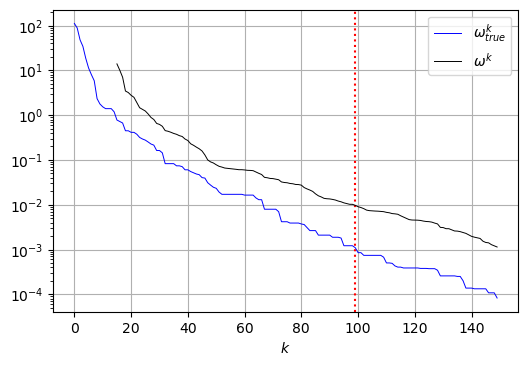

In [9]:
ob.plot_true_rel_gap_uk(lk = prob.lower_bnd, uk = prob.upper_bnd, h_true = h_cvx)